### Y2018M02D16_RH_Number_Streams_Per_Basin_V01

* Purpose of script: determine the number of streams per GDBD basin
* Author: Rutger Hofste
* Kernel used: python35
* Date created: 20180216

Strategy along these lines:
[Strategy](https://gis.stackexchange.com/questions/132723/unsplit-dissolve-multiple-touching-lines-in-stream-network-using-arcgis-desktop)

1. Explode multilines into single lines 
1. Tiny buffer around single lines
1. Take Union
1. Spatial join single line geodataframe and dissolved ID's 
1. Aggregate using polyline ID from previous step

Geopandas is pa pretty inefficient implementation for this problem. Might move this script to postGIS or implement parallelization. 



In [1]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
sys.version

Y2018M02D20 UTC 11:40


'3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 13:26:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [2]:
SCRIPT_NAME = "Y2018M02D16_RH_Number_Streams_Per_Basin_V01"

EC2_INPUT_PATH  = ("/volumes/data/{}/input/").format(SCRIPT_NAME)
EC2_OUTPUT_PATH = ("/volumes/data/{}/output/").format(SCRIPT_NAME)

S3_INPUT_PATH = "s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/"
S3_OUTPUT_PATH = "s3://wri-projects/Aqueduct30/processData/{}/output".format(SCRIPT_NAME)


INPUT_VERSION = 6
OUTPUT_VERSION = 10

TESTING = 0


In [3]:
!rm -r {EC2_INPUT_PATH}
!rm -r {EC2_OUTPUT_PATH}

!mkdir -p {EC2_INPUT_PATH}
!mkdir -p {EC2_OUTPUT_PATH}

In [4]:
!aws s3 cp {S3_INPUT_PATH} {EC2_INPUT_PATH} --recursive

download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_basins_EPSG4326_V06.cpg to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_basins_EPSG4326_V06.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_basins_EPSG4326_V06.prj to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_basins_EPSG4326_V06.prj
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_streams_EPSG4326_V06.cpg to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_streams_EPSG4326_V06.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_basins_EPSG4326_V06.shx to ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_basins_EPSG4326_V06.shx
download: s3://wri-projects/Aqueduct30/processData/Y2018M02D15_RH_GDBD_Merge_V01/output/GDBD_streams_EPSG4326_V06.dbf to ../../../../d

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import eeconvert
import folium
import multiprocessing
from multiprocessing import Pool


%matplotlib inline

In [6]:
file_name_streams = "{}GDBD_streams_EPSG4326_V{:02.0f}.shp".format(EC2_INPUT_PATH,INPUT_VERSION)
file_name_basins = "{}GDBD_basins_EPSG4326_V{:02.0f}.shp".format(EC2_INPUT_PATH,INPUT_VERSION)

In [7]:
print(file_name_streams)

/volumes/data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/input/GDBD_streams_EPSG4326_V06.shp


In [8]:
gdf_streams = gpd.GeoDataFrame.from_file(file_name_streams)
gdf_basins = gpd.GeoDataFrame.from_file(file_name_basins)

In [9]:
gdf_streams_backup = gdf_streams.copy()
tiny_value = 0.0001

if TESTING:
    gdf_streams = gdf_streams[0:(int(67225/10))]
    tiny_value = 0.0001


In [10]:
gdf_streams_backup.shape

(67225, 5)

In [11]:
gdf_basins.shape

(73074, 43)

In [12]:
gdf_streams['GDBD_ID'] = gdf_streams['GDBD_ID'].astype('int64')

In [13]:
gdf_streams.dtypes

OBJECTID        int64
GDBD_ID         int64
Ave_Str_Sl    float64
Shape_Leng    float64
geometry       object
dtype: object

## Functions 

In [14]:
def explode(gdf):
    """
    Will explode the geodataframe's muti-part geometries into single
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index.

    The output geodataframe has an index based on two columns (multi-index)
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
        
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single
                                 geometry as a separate entry in the
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(right=gdf.drop('geometry', axis=1),
                         left_on='level_0',
                         right_index=True)
    gdf_out = (gdf_out.set_index(['level_0', 'level_1'])
                      .set_geometry('geometry'))
    gdf_out.crs = gdf.crs
    return gdf_out


def group_geometry(gdf, buffer_value=0.0001, out_column_name="geometry_group"):
    """
    Adds a column to the dataframe with a geometry group number. The
    group number is determined by overlapping or touching geometries.
    A geodataframe will be exploded before assigning the group number.
    If the input geodataframe contains multi-geometries, the shape will
    increase. This function can also be used to dissolve a geodataframe
    on intersecting geometries instead of attributes. Use this function
    followed by the .dissolve(by='geometry_group') method. 

    Args:
        gdf (gpd.GeoDataFrame)  : input geodataframe with multi-geometries.
        buffer_value (float)    : buffer distance in crs units. Defaults
                                  to 0.0001.
        out_column_name (string): name of output column containing the group
                                  number. Defaults to 'geometry_group'

    Returns:
        gdf (gpd.GeoDataFrame) : geodataframe with new index column
                                 and grouped geometries.
    """
    gdf_polygon = gdf.copy()
    gdf_polygon['geometry'] = gdf_polygon.geometry.buffer(buffer_value,
                                                          resolution=1)
    gdf_polygon["group"] = 1
    gdf_polygon_dissolved = gdf_polygon.dissolve(by="group")
    gdf_out = explode(gdf_polygon_dissolved)
    gdf_out = gdf_out.reset_index()
    gdf_grouped = gpd.GeoDataFrame(gdf_out["level_1"],
                                   geometry=gdf_out.geometry)
    gdf_grouped.rename(columns={'level_1': out_column_name},
                       inplace=True)

    gdf_exploded = explode(gdf)
    gdf_exploded = gdf_exploded.reset_index()
    gdf_exploded_out = gpd.sjoin(gdf_exploded,
                                 gdf_grouped,
                                 how="left",
                                 op='within')
    return gdf_exploded_out


def shrink_buffer(gdf_basins_subset):
    gdf_basins_subset['geometry'] = gdf_basins_subset.geometry.buffer(tiny_value*(-1),
                                                                      resolution=1)
    return gdf_basins_subset


def spatial_join(gdf_basins_subset):
    gdf_joined = gpd.sjoin(gdf_basins_subset, gdf_streams_grouped_simple, how="left", op='intersects')
    gdf_joined_simple = gpd.GeoDataFrame(gdf_joined[["geometry_group","GDBD_ID"]],
                                   geometry=gdf_joined.geometry)
    return gdf_joined_simple

def post_process_results(results):
    df_out = pd.DataFrame()
    for result in results:
        df_out = df_out.append(result)
    return df_out

    

In [15]:
cpu_count = multiprocessing.cpu_count()
print(cpu_count)

8


In [16]:
%%time
# Last clock: Wall time: 12min 34s

gdf_stream_groups = group_geometry(gdf_streams,buffer_value=tiny_value)

CPU times: user 3h 20min 20s, sys: 408 ms, total: 3h 20min 21s
Wall time: 3h 20min 20s


In [17]:
gdf_streams_simple = gpd.GeoDataFrame(gdf_stream_groups["geometry_group"],
                                      geometry=gdf_stream_groups.geometry)

In [18]:
gdf_streams_simple["geometry_group_copy"] = gdf_streams_simple["geometry_group"]

In [19]:
gdf_streams_grouped_simple = gdf_streams_simple.dissolve(by="geometry_group_copy")

In [20]:
gdf_streams_grouped_simple.head()

,geometry,geometry_group
geometry_group_copy,,
0,LINESTRING (-67.22361594961983 -54.20603302347...,0
1,(LINESTRING (-67.83813926892813 -54.5322113372...,1
2,LINESTRING (-68.25348588509797 -53.47400975213...,2
3,LINESTRING (-68.96643793459909 -53.13816119667...,3
4,LINESTRING (-68.45324646817393 -52.88898193107...,4


## Spatially join the hydrobasins with the grouped streamed geodataframes. 

This process take too long (probably appr. 2 hours). Multiprocessing

In [21]:
gdf_split = np.array_split(gdf_basins, cpu_count*100)

In [22]:
%%time
p= Pool()
results_buffered = p.map(shrink_buffer,gdf_split)
p.close()
p.join()
gdf_basins_buffered = post_process_results(results_buffered)

CPU times: user 27.1 s, sys: 712 ms, total: 27.8 s
Wall time: 27.3 s


In [23]:
gdf_split_buffered = np.array_split(gdf_basins_buffered, cpu_count*100)

In [24]:
%%time
# Last clock Wall time: 2min 27s

p= Pool()
results_joined = p.map(spatial_join,gdf_split_buffered)
p.close()
p.join()


CPU times: user 8.5 s, sys: 700 ms, total: 9.2 s
Wall time: 1min 50s


In [25]:
gdf_joined_simple = post_process_results(results_joined)

In [26]:
gdf_match = gdf_joined_simple.loc[gdf_joined_simple["geometry_group"]>=0]

In [27]:
df_out = gdf_match.groupby(['GDBD_ID']).geometry_group.agg(["count"])

In [28]:
df_out = df_out.rename(columns = {"count":"grouped_stream_count"})

In [29]:
gdf_basins_out = gdf_basins.copy()

In [30]:
gdf_basins_out = gdf_basins_out.merge(right=df_out,
                                      how='left',
                                      left_on="GDBD_ID",
                                      right_index=True)

In [31]:
gdf_basins_out.head()

,Accum_Area,Ave_Elev,Ave_Slp,Basin_NO,Cntry_1,Cntry_1_Rt,Cntry_2,Cntry_2_Rt,Cntry_3,Cntry_3_Rt,...,OBJECTID,Pfa_Code,Pop,Pop_Dnsty,Region_NO,Shape_Area,Shape_Leng,SubRegion_,geometry,grouped_stream_count
0,3.374000e+09,229.691,1.08442,1.0,Tanzania,100.0,None,0.0,None,0.0,...,1,10000000.0,34702.0,0.000010,1.0,3.374000e+09,461999.858105,4.0,"POLYGON ((39.47796483150468 -8.9315086242301, ...",1.0
1,1.754200e+10,183.995,1.93185,2.0,Tanzania,100.0,None,0.0,None,0.0,...,2,10000000.0,61860.0,0.000037,1.0,1.664999e+09,296000.153881,4.0,(POLYGON ((39.52518111659099 -9.50270431917738...,1.0
2,1.132000e+09,212.155,1.13653,2.0,Tanzania,100.0,None,0.0,None,0.0,...,3,20000000.0,15080.0,0.000013,1.0,1.132000e+09,199999.920519,4.0,POLYGON ((39.17208889990474 -9.366102390530019...,1.0
3,1.474500e+10,289.598,1.37887,2.0,Tanzania,100.0,None,0.0,None,0.0,...,4,30000000.0,85749.0,0.000032,1.0,2.703001e+09,406000.039104,4.0,(POLYGON ((39.21596758012705 -9.57172654063530...,1.0
4,1.084999e+09,413.781,1.95744,2.0,Tanzania,100.0,None,0.0,None,0.0,...,5,40000000.0,45105.0,0.000042,1.0,1.084999e+09,201999.882989,4.0,POLYGON ((39.16198738230477 -10.09816341628326...,1.0


In [32]:
gdf_basins_deltas = gdf_basins_out.loc[gdf_basins_out["grouped_stream_count"]>=1]

In [33]:
gdf_basins_deltas = gdf_basins_deltas.set_index("GDBD_ID")

In [34]:
gdf_basins_deltas_simple = gpd.GeoDataFrame(gdf_basins_deltas["grouped_stream_count"],
                                            geometry=gdf_basins_deltas.geometry)
                                            

In [35]:
output_path_shp = "{}gdf_streams_group_V{:02.0f}.shp".format(EC2_OUTPUT_PATH,OUTPUT_VERSION)
print(output_path_shp)
output_path_pkl = "{}gdf_streams_group_V{:02.0f}.pkl".format(EC2_OUTPUT_PATH,OUTPUT_VERSION)
print(output_path_pkl)

/volumes/data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.shp
/volumes/data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.pkl


In [36]:
gdf_basins_out.to_file(output_path_shp,driver='ESRI Shapefile')

In [37]:
gdf_basins_out.to_pickle(output_path_pkl)

In [38]:
!aws s3 cp --recursive {EC2_OUTPUT_PATH} {S3_OUTPUT_PATH}

upload: ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.prj to s3://wri-projects/Aqueduct30/processData/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.prj
upload: ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.cpg to s3://wri-projects/Aqueduct30/processData/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.cpg
upload: ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.shx to s3://wri-projects/Aqueduct30/processData/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.shx
upload: ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.dbf to s3://wri-projects/Aqueduct30/processData/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.dbf
upload: ../../../../data/Y2018M02D16_RH_Number_Streams_Per_Basin_V01/output/gdf_streams_group_V10.shp to s3:

/opt/anaconda3/envs/python35/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


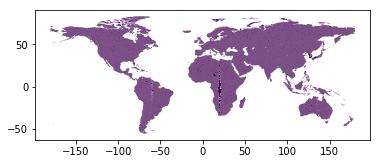

In [39]:
gdf_basins_out.plot(column="grouped_stream_count")

In [40]:
end = datetime.datetime.now()
elapsed = end - start
print(elapsed)

3:27:58.994103
